<a href="https://colab.research.google.com/github/asvnpr/ND_Care_Net/blob/master/USE_embed_serv_sim_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Nodes (Content) Embedding

- use Universal Sentence Encoder to embed nodes from our graph, then embed queries and find most similar services


## Colab Setup
Setup our drive, dependencies, etc. so they're accesible in this notebook.

**Ignore this block if you're not running this in a Colab notebook**

You can get most of this block to work by changing some paths and commands

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
prefix = './drive/My Drive/ND_CSE/Year_1/Research:Care-Net/code_and_data'
!echo "Project dir contents:" && ls "$prefix"
!echo -e "\nColab Notebook home dir:" && ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Project dir contents:
211_IN_Data_Parsing.ipynb    nd_care-net.tar.gz
BANE			     Node_Text_Embedding_Doc2Vec.ipynb
BANE_embeddings.ipynb	     Node_Text_Embedding_GPT-2-Copy1.ipynb
binder			     Node_Text_Embedding_sBERT.ipynb
CX_DB8			     README.md
data			     semantic_embeddings_cluster_plot.ipynb
embeddings		     service_embeddings_UMAP.ipynb
embed_serv_sim_search.ipynb  TENE
figures			     TENE_embeddings.ipynb
Graph_Data_Extraction.ipynb  USE_multi_lang_embed_serv_sim_search.ipynb
models

Colab Notebook home dir:
drive  sample_data


In [0]:
# # install conda
# install_conda = ''
# while install_conda not in ('Y', 'N'):
#   install_conda = input("Do you want to install conda?").upper()
# install_conda = True if install_conda == 'Y' else False 
# if install_conda:
#   !if [ ! -f Miniconda3-latest-Linux-x86_64.sh ]; then wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh; fi
#   !bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local

In [0]:
# env_file = prefix + '/binder/environment.yml'
# !source activate && conda activate && conda env update --file "$env_file"

In [0]:
# load_env = ''
# while load_env not in ('Y', 'N'):
#   load_env = input("Do you want to load the project conda env?").upper()
# load_env = True if load_env == 'Y' else False 
# if load_env:
#   !source activate && conda activate && conda install -c conda-forge -y conda-pack
#   !rm -rf /usr/local/envs/nd_care-net && mkdir -p /usr/local/envs/nd_care-net
#   !tar -xzf './drive/My Drive/ND_CSE/Year_1/Research:Care-Net/code_and_data/nd_care-net.tar.gz' -C /usr/local/envs/nd_care-net/
#   # Cleanup prefixes from in the active environment.
#   # Note that this command can also be run without activating the environment
#   # as long as some version of python is already installed on the machine.
#   !source activate && conda activate nd_care-net && conda-unpack

## Imports, Global Config, and Data

In [0]:
# !pip3 uninstall -y tensorflow-gpu deepdish seaborn tensorflow_text
# !pip3 install tensorflow-gpu==2.0rc0  tf-sentencepiece==0.1.83
!pip3 install annoy h2o4gpu tqdm tabulate nltk tensorflow_text==2.0rc0 umap-learn

In [0]:
#following this guide: https://colab.research.google.com/drive/1t4bi7X7zRzwIjdxUrU2hUs7LneqgYLVK#scrollTo=a73qer_zPJLy
# and: https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_semantic_approximate_nearest_neighbors.ipynb

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
from h2o4gpu.manifold import TSNE
# import matplotlib.pyplot as plt
import numpy as np
from h2o4gpu.metrics.pairwise import cosine_similarity
import seaborn as sns
import annoy
import umap

import json
import os
import csv
import pickle
import pandas as pd

import random
import typing
from itertools import chain
import string

from tqdm import tqdm, trange
from tabulate import tabulate
import logging

import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import download as nltk_dl
from nltk.stem import WordNetLemmatizer
nltk_dl('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
# make sure we're using a gpu or hw acceleration before we start embedding!!
# NOTE: not working. clearly connected to GPU
if not tf.test.is_gpu_available() and 'COLAB_TPU_ADDR' not in os.environ:
  print("WARNING!: This notebook is not connected to a GPU nor TPU runtime.")
else:
  print("HW Acceleration should work :)")

HW Acceleration should work :)


In [0]:
# open our datasets
with open(prefix + '/data/services_nodes.json') as sn:
    serv_nodes = json.loads(sn.read())
    
with open(prefix + '/data/services_edgelist.csv') as se:
    serv_edges = csv.reader(se)

# TODO: refacto var name to something more accurate and general
with open(prefix + '/data/HIN_nodes.json') as taxo:
    taxo_nodes = json.loads(taxo.read())

with open(prefix + '/data/code_to_node_num.json') as cn:
    code_trans = json.loads(cn.read())

In [0]:
NODE_TYPE = 'services'
BATCH_SIZE = 256
NUM_NODES = len(serv_nodes)
NUM_BATCHES =  NUM_NODES // BATCH_SIZE

MODEL = 'USE'
# MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
# MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/2'
# MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'
MODEL_TYPE = MODEL_URL.split('/')[-2]
MODEL_VER = MODEL_URL.split('/')[-1]

!mkdir -p "$prefix/embeddings/$MODEL/"
print("Using Model {}_{}_v{}".format(MODEL, MODEL_TYPE, MODEL_VER))

Using Model USE_universal-sentence-encoder_v4


## Pre-process our text data

In [0]:
# adapted from: https://towardsdatascience.com/machine-learning-text-processing-1d5a2d638958
# and: https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908
# and TF2.0 example: https://tfhub.dev/google/universal-sentence-encoder-large/5

# some of the other models I use process texts as a list of sentences
# preprocess for all cases since combining inro full text is trivial
def preprocess_text(text: str) -> typing.List :
    # normalize: convert to lower, remove 
    # numbers, remove punctuation
    text = text.lower()
    
    # tokenize into sentences
    text_sents = nltk.sent_tokenize(text)
    # proc_sents = text_sents
    proc_sents = []

    for sent in text_sents:

      words = []
      # remove digits 
      sent = sent.translate(str.maketrans('','', string.digits))
      # remove punctuation
      sent = sent.translate(str.maketrans('','',string.punctuation))
      # split into word tokens
      sent_words = nltk.word_tokenize(sent)

      # print(sent_words)
      stop_words = set(stopwords.words('english'))
      # remove stopwords like 'the', 'is', 'a', etc
      words = [w for w in sent_words if w not in stop_words]
      # get base form of words
      lemmer = WordNetLemmatizer()
      words = [lemmer.lemmatize(w) for w in words]
      # join words back into sentence
      proc_sents.append(' '.join(words))
      

    return proc_sents

In [0]:
# service features to be embedded as text or tags
text_feats = [
    'name', 
    'akas', 
    'description', 
    'codes',
    'eligibility'
]

docs = []
tagged_texts = {}

if os.path.exists(os.path.join(prefix, 'data', 'tagged_texts.json')):
  with open(os.path.join(prefix, 'data', 'tagged_texts.json')) as ttf:
    tagged_texts = json.load(ttf)

else:
  # for each service node
  with tqdm(total=NUM_NODES, desc='Pre-processing Text') as pbar:
    
      for node_num in serv_nodes:

        node = serv_nodes[node_num]
        node_sents = []
        node_text = ''
        # preprocess the text content of the node and it's taxonomy code nodes

        for feat in text_feats:

            text = node[feat]
            if feat in ('akas', 'eligibility') and text:
                if len(text) > 1:
                  if isinstance(text, str):
                    print(text)
                  text = '. '.join(text)
                else:
                  text = text[0]
                # node_sents.extend(preprocess_text(text))
                node_text += text + '. '


            elif feat == 'codes':
                for cn in node[feat]:
                    code = taxo_nodes[str(code_trans[cn])]
                    # node_sents.extend(preprocess_text(code['name']))
                    node_text += code['name'] + '. '
                    # node_sents.extend(preprocess_text(code['description']))
                    node_text += code['description'] + '. '
                    if 'keywords' in code:
                      keywords = code['keywords']
                      if isinstance(keywords, str):
                        keywords = [keywords]
                      if len(keywords) > 1:
                        keywords = '. '.join(keywords)
                      else:
                        keywords = keywords[0]
                      # node_sents.extend(preprocess_text(keywords))
                      node_text += keywords + '. '

            # some node features are empty
            elif text:
                # node_sents.extend(preprocess_text(text))
                node_text += text + '. '

        node_sents = preprocess_text(node_text)
        # print(np.array(node_sents).shape)
        pbar.update(1)
        tagged_texts[node_num] = node_sents

In [0]:
def save_to_json(data, name):
  path = os.path.join(prefix, 'data', name)
  data_json = json.dumps(data)
  with open(path, 'w') as djf:
    djf.write(data_json)

In [0]:
sample = random.choices(list(tagged_texts.items()), k=2)
sample = list(map(lambda t: (t[0], '\n'.join(t[1])), sample))
print(tabulate(sample))

-----  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
31188  domestic violence shelter
       offer temporary shelter support service woman men fleeing domestic violence sexual assult situation child
       maximum stay day
       crisis intake available hour per day
       longterm transitional housing may available passage way completed stay better way domestic violence shelter
       program provide temporary emergency shelter individual primarily woman experienced domestic violenceabuse child
       facility usually provide inhouse individual group family counseling full range secondary service related domestic violence including referral appropriate resource
       also included similar facility battered men accommodate men woman available abused woman shelter
       assaulted woman shelter
       battered men shelter
       ba

In [0]:
save_to_json(data=tagged_texts, name='tagged_texts.json')

## Get embeddings from our text data 

In [0]:
tagged_embeds = {}

# generates embedding from model loaded from tf hub
def generate_embeds(text, embed_fn=None):
  if embed_fn is None:
    embed_fn = hub.load(MODULE_URL)
  
  # older versions return a dict with a Tensor
  # newer versions return the Tensor directly
  # on either we need to extract the numpy array
  embedding = embed_fn(text).numpy()
#   embedding = embed_fn(text)['outputs'].numpy()
  return embedding

# processes text to embed in batches
def process_embed_batches(tagged_texts, module_url=MODEL_URL):

  #load tensorflow hub module (weights)
  embedder = hub.load(module_url)
  print("Successfully Loaded Model...")

  # setup progress bar
  descr = 'Embedding node text content'
  with tqdm(total=NUM_NODES, dynamic_ncols=True, desc=descr) as pbar:
    
    text_nodes = list(tagged_texts.items())
    # for each node, embed it's text content. save in tagged dict
    y = 0
    for i in range(0, NUM_NODES, BATCH_SIZE):

        text_embeds = []
        # grab BATCH_SIZE number of samples
        # separate list of tuples into separate lists
        batch_ids, batch_sents = list(zip(*text_nodes[i:i+BATCH_SIZE]))
        # USE embeddings expects the full text instead of separate sentences
        # flatten our list of lists of sentences into a list of full text
        batch_texts = ['\n'.join(sents) for sents in batch_sents]

        text_embeds = generate_embeds(text=batch_texts, embed_fn=embedder)
        # sent_embeds = np.concatenate(sent_embeds, axis=0)
        for idx, embed in zip(batch_ids, text_embeds):
          # save the node id and it's text embedding
          tagged_embeds[idx] = {'embed': embed}

        y += 1
        pbar.update(BATCH_SIZE)
        if y % 1000 == 0 or (NUM_BATCHES - y) < 1000:
          print("Processed Batch {}/{}".format(y, NUM_BATCHES))
          
  return tagged_embeds



In [0]:
embed_path = os.path.join(prefix, 'embedding', MODEL, "{}_{}_v{}.pkl".format(
    NODE_TYPE, MODEL_TYPE, MODEL_VER
    ))
if os.path.exists(embed_path):
  print("Loading embeddings from {}".format(embed_path))
  with open(embed_path, 'rb') as f:
        tagged_embeds = pickle.load(f)
else:
  tagged_embeds = process_embed_batches(tagged_texts=tagged_texts, module_url=MODEL_URL)

Embedding node text content:   0%|          | 0/16547 [00:00<?, ?it/s]

Successfully Loaded Model...


Embedding node text content:   5%|▍         | 768/16547 [00:00<00:16, 950.91it/s]

Processed Batch 1/64
Processed Batch 2/64
Processed Batch 3/64


Embedding node text content:   9%|▉         | 1536/16547 [00:00<00:10, 1416.64it/s]

Processed Batch 4/64
Processed Batch 5/64
Processed Batch 6/64


Embedding node text content:  12%|█▏        | 2048/16547 [00:00<00:08, 1673.41it/s]

Processed Batch 7/64
Processed Batch 8/64
Processed Batch 9/64


Embedding node text content:  19%|█▊        | 3072/16547 [00:01<00:06, 2116.79it/s]

Processed Batch 10/64
Processed Batch 11/64
Processed Batch 12/64


Embedding node text content:  22%|██▏       | 3584/16547 [00:01<00:05, 2242.07it/s]

Processed Batch 13/64
Processed Batch 14/64


Embedding node text content:  26%|██▋       | 4352/16547 [00:01<00:05, 2348.66it/s]

Processed Batch 15/64
Processed Batch 16/64
Processed Batch 17/64


Embedding node text content:  29%|██▉       | 4864/16547 [00:02<00:04, 2381.55it/s]

Processed Batch 18/64
Processed Batch 19/64


Embedding node text content:  32%|███▏      | 5376/16547 [00:02<00:04, 2400.70it/s]

Processed Batch 20/64
Processed Batch 21/64


Embedding node text content:  36%|███▌      | 5888/16547 [00:02<00:04, 2453.70it/s]

Processed Batch 22/64
Processed Batch 23/64


Embedding node text content:  39%|███▊      | 6400/16547 [00:02<00:04, 2413.38it/s]

Processed Batch 24/64
Processed Batch 25/64


Embedding node text content:  42%|████▏     | 6912/16547 [00:02<00:04, 2407.56it/s]

Processed Batch 26/64
Processed Batch 27/64
Processed Batch 28/64


Embedding node text content:  46%|████▋     | 7680/16547 [00:03<00:03, 2435.47it/s]

Processed Batch 29/64
Processed Batch 30/64
Processed Batch 31/64


Embedding node text content:  53%|█████▎    | 8704/16547 [00:03<00:02, 2654.13it/s]

Processed Batch 32/64
Processed Batch 33/64
Processed Batch 34/64


Embedding node text content:  56%|█████▌    | 9216/16547 [00:03<00:02, 2638.21it/s]

Processed Batch 35/64
Processed Batch 36/64
Processed Batch 37/64


Embedding node text content:  62%|██████▏   | 10240/16547 [00:04<00:02, 2718.83it/s]

Processed Batch 38/64
Processed Batch 39/64
Processed Batch 40/64


Embedding node text content:  65%|██████▍   | 10752/16547 [00:04<00:02, 2735.69it/s]

Processed Batch 41/64
Processed Batch 42/64
Processed Batch 43/64


Embedding node text content:  71%|███████   | 11776/16547 [00:04<00:01, 2689.71it/s]

Processed Batch 44/64
Processed Batch 45/64
Processed Batch 46/64


Embedding node text content:  74%|███████▍  | 12288/16547 [00:04<00:01, 2702.01it/s]

Processed Batch 47/64
Processed Batch 48/64


Embedding node text content:  77%|███████▋  | 12800/16547 [00:05<00:01, 2631.14it/s]

Processed Batch 49/64
Processed Batch 50/64
Processed Batch 51/64


Embedding node text content:  84%|████████▎ | 13824/16547 [00:05<00:00, 2745.38it/s]

Processed Batch 52/64
Processed Batch 53/64
Processed Batch 54/64


Embedding node text content:  87%|████████▋ | 14336/16547 [00:05<00:00, 2718.22it/s]

Processed Batch 55/64
Processed Batch 56/64
Processed Batch 57/64


Embedding node text content:  93%|█████████▎| 15360/16547 [00:06<00:00, 2839.99it/s]

Processed Batch 58/64
Processed Batch 59/64
Processed Batch 60/64


Embedding node text content:  96%|█████████▌| 15872/16547 [00:06<00:00, 2840.57it/s]

Processed Batch 61/64
Processed Batch 62/64
Processed Batch 63/64


Embedding node text content: 16640it [00:06, 2582.24it/s]                           

Processed Batch 64/64
Processed Batch 65/64


In [0]:
def save_to_pickle(data, path=None):
  if path is not None:
    path = os.path.join(prefix, path)
  else:  
    path = os.path.join(prefix, 'embeddings', MODEL, "{}_{}_v{}.pkl".format(
      NODE_TYPE, MODEL_TYPE, MODEL_VER
    ))
  with open(path, 'ab') as f:
        pickle.dump(data, f)

In [0]:
save_to_pickle(tagged_embeds)

## Sanity Check
Make sure our embeddings make sense by comparing them all against each other. The most similar one should be itself (ie the matrix diagonal). 

In [0]:
# adapted from: https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb#scrollTo=h1FFCTKm7ba4

def plot_similarity(names, features, rotation):
  # pair wise cosine similarity between all elements in the matrix
  corr = cosine_similarity(features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=names,
      yticklabels=names,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(names, rotation=rotation)
  g.set_title("Semantic Textual Similarity: Self-Comparison")

def run_and_plot(names, embeds):
  plot_similarity(names, embeds, rotation=90)

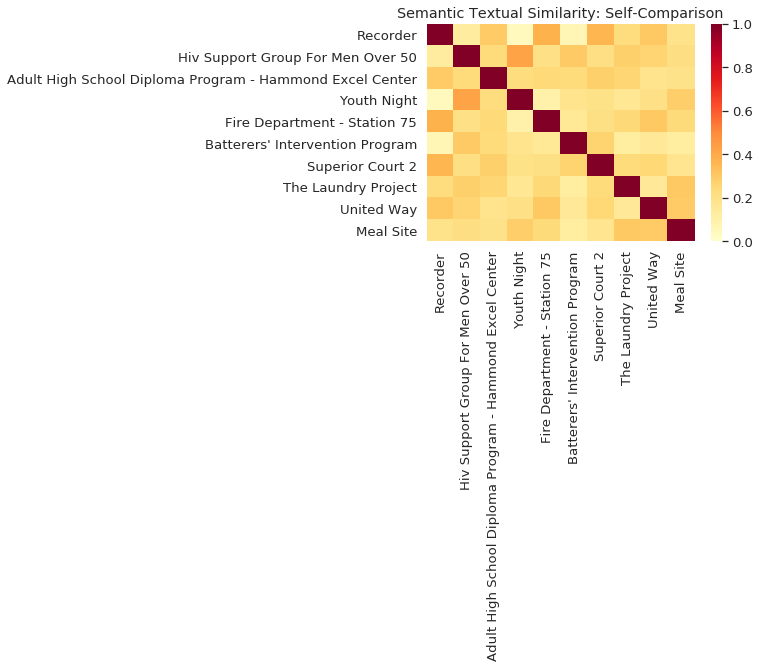

In [0]:
node_names = [taxo_nodes[idx]['name'] for idx in tagged_texts]
node_embeds = [tagged_embeds[idx]['embed'] for idx in tagged_embeds]
node_texts = ['\n'.join(tagged_texts[idx]) for idx in tagged_embeds]
node_ids = list(tagged_embeds.keys())

paired = list(zip(node_names, node_embeds))
paired = random.sample(paired, 10)
name_smpls, embed_smpls = zip(*paired)
run_and_plot(names=name_smpls, embeds=embed_smpls)